In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import pyamg
from IPython.display import clear_output
plt.style.use("ggplot")
from matplotlib.pyplot import *
from matplotlib.lines import Line2D
import powerlaw
%matplotlib inline
from IPython.display import set_matplotlib_formats
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (12,7)

# Define IID random matrix class

In [2]:
def bernoulli(size,cplx=True):
    if cplx: 
        return ((2*np.random.binomial(1,.5,size=size)-1)+1j*(2*np.random.binomial(1,.5,size=size)-1))/np.sqrt(2)
    else:
        return (2*np.random.binomial(1,.5,size=size)-1)
def normal(size,cplx=True):
    if cplx: 
        return (np.random.normal(size=size)+1j*np.random.normal(size=size))/np.sqrt(2)
    else:
        return np.random.normal(size=size)
def uniform(size,cplx=True):
    if cplx: 
        return (np.random.uniform(size=size)+1j*np.random.uniform(size=size))*np.sqrt(6)
    else:
        return np.random.uniform(size=size)*np.sqrt(12)
class iid:
    def __init__(self,n,k=1,cplx=True,dist=normal):
        self.n = n
        self.k = k
        self.eigs = np.zeros((k,n))
        self.sing = np.zeros((k,n))
        self.Xs = np.zeros((k,n,n),dtype=complex)
        self.Xz = np.zeros((k,n,n),dtype=complex)
        self.W = np.zeros((k,2*n,2*n),dtype=complex)
        self.eigvals = []; self.leigvecs = []; self.reigvecs = [];
        self.ovs = np.zeros((k,n))
        for j in range(k):
            self.Xs[j] = dist(size=(n,n),cplx=cplx)/np.sqrt(n)
            w, vl, vr = scipy.linalg.eig(self.Xs[j], left=True)
            self.ovs[j]=np.abs(np.diag(vl.T.conj()@vr))**(-2)
            self.eigvals.append(w)
            self.leigvecs.append(vl)
            self.reigvecs.append(vr)
            self.W[j,:n,n:] = self.Xs[j]
            self.W[j,n:,:n] = self.Xs[j].conjugate().transpose()
        self.eigvals=np.array(self.eigvals); self.leigvecs=np.array(self.leigvecs); self.reigvecs=np.array(self.reigvecs)
    def uv(self,z):
        u,s,v=self.svdnc(z,compute_uv=True)
        return (np.sum(v[:,-1,:]*u[:,:,-1],axis=1),s[:,-1])
    def svdnc(self,z,compute_uv=False):
        Xsz=self.Xs-z*np.eye(self.n)
        return np.linalg.svd(Xsz,compute_uv=compute_uv)

# Circular law + density plot

In [3]:
n=1000
XR=iid(n,cplx=False)
XC=iid(n,cplx=True)

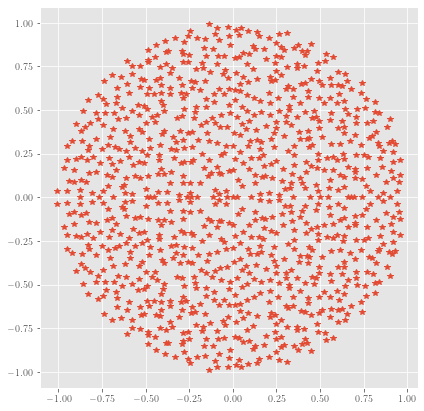

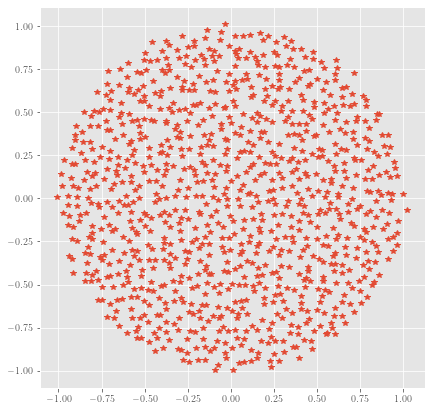

In [4]:
plt.plot(np.real(XR.eigvals[0]),np.imag(XR.eigvals[0]),"*")
plt.gca().set_aspect('equal')
plt.show()
plt.plot(np.real(XC.eigvals[0]),np.imag(XC.eigvals[0]),"*")
plt.gca().set_aspect('equal')
plt.show()

In [5]:
def mIID(z,ws):
    if isinstance(ws,complex):
        w=ws
        coef = [1,2*w,1+w**2-np.abs(z)**2,w]
        sols = np.roots(coef)
        return sols[np.imag(sols)*np.imag(w)>0][0]
    else:
        return np.array([mIID(z,w) for w in ws])
def reim(zs):
    return np.array([np.real(zs),np.imag(zs)])

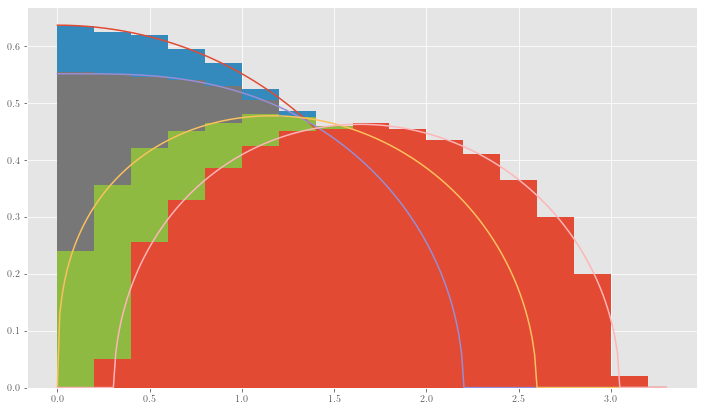

In [6]:
xs=np.linspace(0,3.3,251)
zs=np.array([0,.5,1,1.5])*np.exp(1j*np.pi/4)
bins=np.linspace(0,3.2,17)
for z in zs:
    rhos=2*np.imag(mIID(z,xs+.0000001j))/np.pi
    plt.plot(xs,rhos)
    plt.hist(XR.svdnc(z)[0],bins,density=True)
plt.show()

In [7]:
np.savetxt("histSing.csv",np.concatenate([[bins[:-1]],[np.histogram(XR.svdnc(z)[0], bins=bins,density=True)[0] for z in zs]]).T,delimiter=",")
np.savetxt("rhosSing.csv",np.concatenate([[xs],[2*np.imag(mIID(z,xs+.0000001j))/np.pi for z in zs]]).T,delimiter=",")
np.savetxt("500r.csv",reim(XR.eigvals[0]).T,delimiter=",")
np.savetxt("500c.csv",reim(XC.eigvals[0]).T,delimiter=",")
np.savetxt("500zs.csv",reim(zs).T,delimiter=",")

# Expected overlap plot

CPU times: user 1min 40s, sys: 4.23 s, total: 1min 44s
Wall time: 33.8 s
CPU times: user 1min 31s, sys: 4.78 s, total: 1min 36s
Wall time: 40.2 s


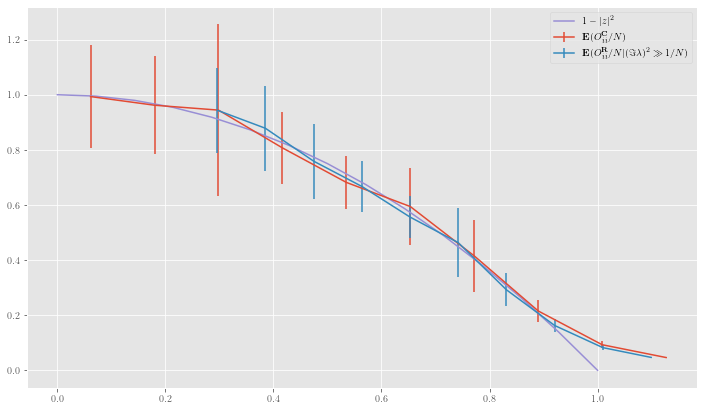

In [8]:
n=100
Xs=%time iid(n,1000)
XsR=%time iid(n,1000,cplx=False)

ovsC=Xs.ovs.reshape(-1)
eigsC=Xs.eigvals.reshape(-1)

binsR=[0,n**(-.5)/20,n**(-.5)*2.5,2]
ovsR=XsR.ovs.reshape(-1)
eigsR=XsR.eigvals.reshape(-1)
digi=np.digitize(np.abs(np.imag(eigsR)),binsR)
eigsR=[ eigsR[digi==i] for i in range(1,len(binsR))]
ovsR=[ ovsR[digi==i] for i in range(1,len(binsR))]

means,bins,_=scipy.stats.binned_statistic(np.abs(eigsC),ovsC,"mean")
stds,_,_=scipy.stats.binned_statistic(np.abs(eigsC),ovsC,"std")
meansRC,binsRC,_=scipy.stats.binned_statistic(np.abs(eigsR[-1]),ovsR[-1],"mean")
stdsRC,_,_=scipy.stats.binned_statistic(np.abs(eigsR[-1]),ovsR[-1],"std")
plt.errorbar((bins[1:]+bins[:-1])/2,means/n,yerr=stds/n**1.5,label="$\\mathbf E(O_{ii}^{\\mathbf C}/N)$")
plt.errorbar((binsRC[1:]+binsRC[:-1])/2,meansRC/n,yerr=stdsRC/n**1.5,label="$\\mathbf E(O_{ii}^{\\mathbf R}/N\\vert (\Im\lambda)^2\gg 1/N)$")
xs=np.linspace(0,1,15)
plt.plot(xs,1-xs**2,label="$1-|z|^2$")
plt.legend()
plt.show()

In [9]:
np.savetxt("eOV.csv",np.array([(bins[1:]+bins[:-1])/2,means/n,stds/n**1.5,(binsRC[1:]+binsRC[:-1])/2,meansRC/n,stdsRC/n**1.5]).T,delimiter=",")

# CDF overlap plot

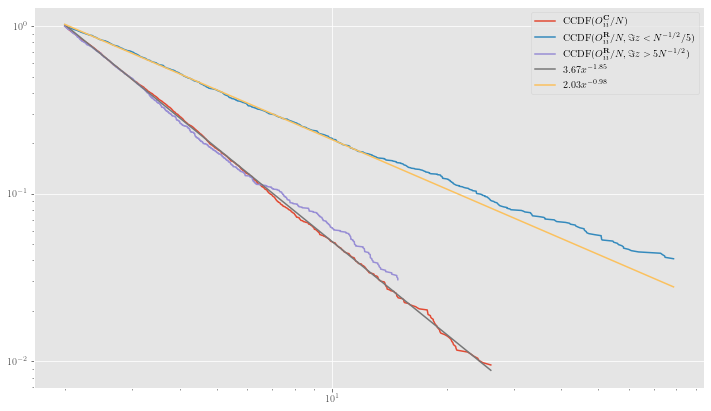

In [12]:
fitC=powerlaw.Fit(ovsC/n,xmin=2.)
fitR=[powerlaw.Fit(ovsR[i]/n,xmin=2.) for i in range(len(ovsR))]

xsC,ysC=fitC.ccdf()
xsC=xsC[:-30]
ysC=ysC[:-30]
xsR=[]
ysR=[]
for fit in fitR:
    xst,yst=fit.ccdf()
    ysR.append(yst[:-50])
    xsR.append(xst[:-50])
plt.loglog(xsC,ysC,label="$\mathrm{CCDF}(O_{ii}^{\mathbf C}/N)$")
exps=[]
plt.loglog(xsR[0],ysR[0],label="$\mathrm{CCDF}(O_{ii}^{\mathbf R}/N, \Im z<N^{-1/2}/5)$")
plt.loglog(xsR[2],ysR[2],label="$\mathrm{CCDF}(O_{ii}^{\mathbf R}/N, \Im z>5N^{-1/2})$")
#plt.loglog(xsRR,ysRR,label="$\mathrm{CCDF}(O_{ii}^{\mathbf R,\mathbf R}/N)$")
#plt.loglog(xsRS,ysRS,label="$\mathrm{CCDF}(O_{ii}^{\mathbf R,S}/N)$")
coefsC=np.polyfit(np.log(xsC[:-200]),np.log(ysC[:-200]),1)
coefsRR=np.polyfit(np.log(xsR[0][:-200]),np.log(ysR[0][:-200]),1)
plt.loglog(xsC,np.exp(coefsC[1])*xsC**(coefsC[0]),label="${:.2f}x^{{{:.2f}}}$".format(np.exp(coefsC[1]),coefsC[0]))
plt.loglog(xsR[0],np.exp(coefsRR[1])*xsR[0]**(coefsRR[0]),label="${:.2f}x^{{{:.2f}}}$".format(np.exp(coefsRR[1]),coefsRR[0]))
plt.legend()
plt.show()

In [13]:
idxC=np.cumsum(np.bincount((99*np.log(xsC/xsC[0])/np.log(xsC[-1]/xsC[0])).astype(int)))-1
idxRR=np.cumsum(np.bincount((99.5*np.log(xsR[0]/xsR[0][0])/np.log(xsR[0][-1]/xsR[0][0])).astype(int)))-1
idxRC=np.cumsum(np.bincount((99.5*np.log(xsR[2]/xsR[2][0])/np.log(xsR[2][-1]/xsR[2][0])).astype(int)))-1

np.savetxt("ovDecay.csv",np.array([xsC[idxC],ysC[idxC],xsR[0][idxRR],ysR[0][idxRR],xsR[2][idxRC],ysR[2][idxRC]]).T,delimiter=",")

# CDF kappa plot

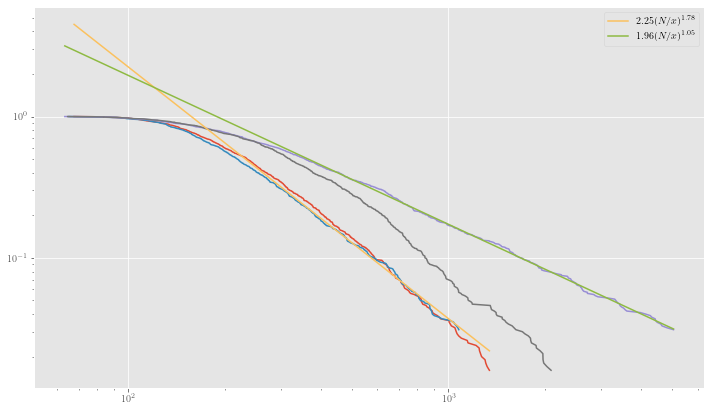

In [14]:
n=100
k=1000
XsC=iid(n,k,cplx=True)
XsR=iid(n,k,cplx=False)
kappaC=XsC.svdnc(0)[:,0]/XsC.svdnc(0)[:,-1]
kappaRC=XsR.svdnc(.5j)[:,0]/XsR.svdnc(.5j)[:,-1]
kappaRR=XsR.svdnc(0)[:,0]/XsR.svdnc(0)[:,-1]
kappaRS=XsR.svdnc(.3*n**(-.5)*1j)[:,0]/XsR.svdnc(.3*n**(-.5)*1j)[:,-1]

fitC=powerlaw.Fit(kappaC,xmin=.1)
xsC,ysC=fitC.ccdf()
fitRC=powerlaw.Fit(kappaRC,xmin=.1)
xsRC,ysRC=fitRC.ccdf()
fitRR=powerlaw.Fit(kappaRR,xmin=.1)
xsRR,ysRR=fitRR.ccdf()
xsC=xsC[:-15];ysC=ysC[:-15]
xsRC=xsRC[:-30];ysRC=ysRC[:-30]
xsRR=xsRR[:-30];ysRR=ysRR[:-30]
fitRS=powerlaw.Fit(kappaRS,xmin=.1)
xsRS,ysRS=fitRS.ccdf()
xsRS=xsRS[:-15];ysRS=ysRS[:-15]
plt.loglog(xsC,ysC)
plt.loglog(xsRC,ysRC)
plt.loglog(xsRR,ysRR)
plt.loglog(xsRS,ysRS)
coefsC=np.polyfit(np.log(xsC[800:]/n),np.log(ysC[800:]),1)
coefsRC=np.polyfit(np.log(xsRC[800:]/n),np.log(ysRC[800:]),1)
coefsRR=np.polyfit(np.log(xsRR[800:]/n),np.log(ysRR[800:]),1)
plt.loglog(xsC,np.exp(coefsRC[1])*(xsC/n)**(coefsRC[0]),label="${:.2f} (N/x)^{{{:.2f}}}$".format(np.exp(coefsRC[1]),-coefsRC[0]))
plt.loglog(xsRR,np.exp(coefsRR[1])*(xsRR/n)**(coefsRR[0]),label="${:.2f} (N/x)^{{{:.2f}}}$".format(np.exp(coefsRR[1]),-coefsRR[0]))
plt.legend()
plt.show()

In [15]:
idxC=np.cumsum(np.bincount((99*np.log(xsC/xsC[0])/np.log(xsC[-1]/xsC[0])).astype(int)))-1
idxRR=np.cumsum(np.bincount((99.5*np.log(xsRR/xsRR[0])/np.log(xsRR[-1]/xsRR[0])).astype(int)))-1
idxRC=np.cumsum(np.bincount((99.5*np.log(xsRC/xsRC[0])/np.log(xsRC[-1]/xsRC[0])).astype(int)))-1
idxRS=np.cumsum(np.bincount((99*np.log(xsRS/xsRS[0])/np.log(xsRS[-1]/xsRS[0])).astype(int)))-1
np.savetxt("kappaDecay.csv",np.array([xsC[idxC],ysC[idxC],xsRC[idxRC],ysRC[idxRC],xsRR[idxRR],ysRR[idxRR],xsRS[idxRS],ysRS[idxRS]]).T,delimiter=",")

# CG plot

In [16]:
def niter(A,b,tol=1e-8,maxiter=None,result=False,algo=pyamg.krylov.gmres,sq=False):
    resvar=[]
    if maxiter is None:
        maxiter=5*len(b)
    if sq:
        A=A@A.conj().T
    res=algo(A,b,maxiter=maxiter,tol=tol,residuals=resvar)
    if res[1] != 0:
        print("no convergence")
    if result:
        return (len(resvar),res[0],np.abs(resvar))
    else:
        return len(resvar)

In [18]:
results=[]
tol=1e-8
n=100
rep=3200
for k in range(rep):
    if k % 100 == 0:
        print(k)
    Xg=normal((n,n),cplx=False)/np.sqrt(n)
    Xgc=normal((n,n),cplx=True)/np.sqrt(n)
    Xb=bernoulli((n,n),cplx=False)/np.sqrt(n)
    Xg1=np.identity(n)*.5+Xg
    Xgi=np.identity(n)*.5j+Xg
    Xgc1=np.identity(n)*.5+Xgc
    Xgci=np.identity(n)*.5j+Xgc
    Xb1=np.identity(n)*.5+Xb
    Xbi=np.identity(n)*.5j+Xb
    bg=normal((n,),cplx=False)/np.sqrt(n)
    bu=uniform((n,),cplx=False)/np.sqrt(n)
    bgc=normal((n,),cplx=True)/np.sqrt(n)
    bb=bernoulli((n,),cplx=False)/np.sqrt(n)
    nXg1=niter(Xg1,bu,tol=tol,algo=pyamg.krylov.cg,sq=True)
    nXgi=niter(Xgi,bu,tol=tol,algo=pyamg.krylov.cg,sq=True)
    nXgc1=niter(Xgc1,bu,tol=tol,algo=pyamg.krylov.cg,sq=True)
    nXgci=niter(Xgci,bu,tol=tol,algo=pyamg.krylov.cg,sq=True)
    nXb1=niter(Xb1,bu,tol=tol,algo=pyamg.krylov.cg,sq=True)
    nXbi=niter(Xbi,bu,tol=tol,algo=pyamg.krylov.cg,sq=True)
    results.append([nXg1,nXgi,nXb1,nXbi,nXgc1,nXgci])

clear_output()

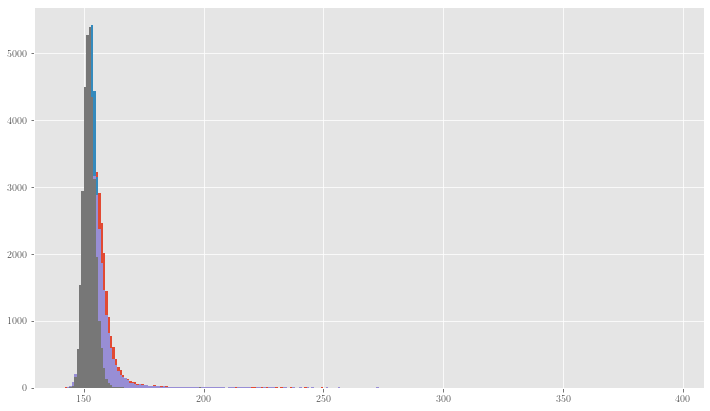

In [ ]:
results=np.array(results)
rmin=np.min(results[results<500])
rmax=np.max(results[results<500])
for i in range(4):
    plt.hist(results[results[:,i]<500,i],np.linspace(rmin,rmax,rmax-rmin+1))
plt.show()

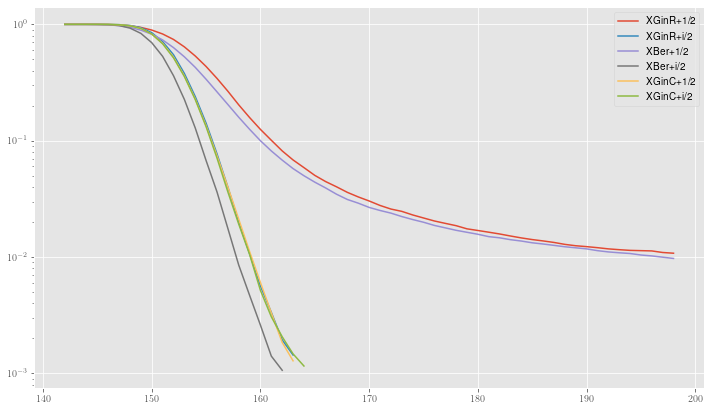

In [ ]:
ccdf=[[np.mean(results[:,i]>k) for k in range(rmin,rmax)] for i in range(6)]
ccdfnan=np.array(ccdf)
ccdfnan[ccdfnan<1e-3]=np.NAN
labels=["XGinR+1/2","XGinR+i/2","XBer+1/2","XBer+i/2","XGinC+1/2","XGinC+i/2"]
for i in range(6):
    #le=np.sum(np.array(ccdf[i])>1e-3)
    plt.semilogy(range(rmin,rmax),ccdfnan[i],label=labels[i])
plt.legend()
plt.show()

In [ ]:
rmin=np.min(results[results<200])
rmax=np.max(results[results<200])
np.savetxt("CGtail.csv",np.concatenate([[np.array(range(rmin,rmax))],ccdfnan]).T,delimiter=",")
np.savetxt("CG.csv",np.concatenate([[np.linspace(rmin,rmax,rmax-rmin+1)],np.array([np.histogram(results[results[:,i]<200,i], bins=range(rmin,rmax+2),density=True)[0] for i in range(6)])]).T,delimiter=",")